# CL2 - Intro to Convolution Neural Networks in PyTorch

As mentioned in CL1, Pytorch will be essential in this course.
In this computer lab we'll dig deeper into this module with an example of how to define, train, and assess the performance of convolutional neural networks, using Pytorch. For this task, we will use the MNIST dataset, which is comprised of 70.000 28x28 grayscale images of handwritten digits (60k for training, 10k for testing).

Our goal is to build a convolutional neural network that takes as input the grayscale image of a handwritten digit, and outputs its corresponding label.

---
## 1. Loading and visualizing the data

We will start by downloading the MNIST dataset using the `MNIST` function. If this is the first time you're running this cell, you will need internet access to download the dataset.

MNIST is a popular dataset, that is often used for prototyping and demonstrations. That is why Pytorch comes with a predefined MNIST dataset. In general, it is a lot more work to create a dataset.

Recently, there has been some issues with the official hosting of `MNIST`, and you can actually get a small taste of the tedious work of dataset management.
If the below command does not work out of the box, you will need to manually do a few steps:
- Download the `MNIST`, e.g., from [here](https://deepai.org/dataset/mnist)
- Create a folder `MNIST/raw/` in the current folder, i.e., the `CL2` folder where this notebook is in.
- Move the downloaded zip file to the `MNIST/raw/` folder and unzip it. Your file structure should now look like this:
  ```bash
  MNIST
  └── raw
    ├── t10k-images-idx3-ubyte.gz
    ├── t10k-labels-idx1-ubyte.gz
    ├── train-images-idx3-ubyte.gz
    └── train-labels-idx1-ubyte.gz
  ```
- Rerun the below command.

In [1]:
import torch
from torchvision import datasets, transforms

train_data = datasets.MNIST('./', train=True, download=False, transform=transforms.ToTensor())
x_train = train_data.data
y_train = train_data.targets

test_data = datasets.MNIST('./', train=False, download=False, transform=transforms.ToTensor())
x_test = test_data.data
y_test = test_data.targets

Let's explore the data.
Pytorch is built on top of the more basic module Numpy.
Because of this, the `torch.Tensor` object has many of the methods you recognise from a `numpy array`,
such as `shape`, `sum()`, `min()`, `max()` et c.

We can see the range of pixel values by running the following cell:

In [2]:
print('Min: {}\nMax: {}'.format(x_train.min(), x_train.max()))

Min: 0
Max: 255


We can also inspect the shapes of the training set:

In [3]:
x_train.shape

torch.Size([60000, 28, 28])

In [4]:
y_train.shape

torch.Size([60000])

The shape of `x_train` can be interpreted as (samples, width, height). So we can see that the training set is comprised indeed of 60k images, each 28x28. Doing the same for the test set:

In [5]:
x_test.shape

torch.Size([10000, 28, 28])

In [6]:
y_test.shape

torch.Size([10000])

shows us that we have 10k images in the test set, also 28x28. We can take a look at one of the examples in the training set by simply indexing `x_train` in its first dimension:

In [7]:
x_train[10]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  42, 118, 219,
         166, 118, 118,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 103, 242, 254, 254,
         254, 254, 254,  66,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

Which shows the 11th (remember, arrays are zero-indexed) data point in the training set as a matrix of numbers (note that the numbers range from 0 to 255, we'll normalize that later for easier training). Since we know that each example is actually a grayscale image of a handwritten digit, is more conveninent to display it as an image instead:

In [8]:
import matplotlib.pyplot as plt

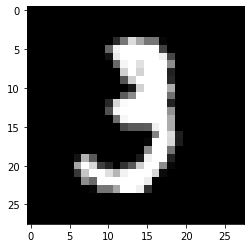

In [9]:
plt.imshow(x_train[10], cmap='gray')

We can see the corresponding ground truth label by indexing `y_train` with the same index.

In [10]:
y_train[10]

tensor(3)

## 2. Preprocessing

We need to normalize the inputs to range from 0 to 1 (instead of 0 to 255):

In [11]:
x_train_norm = x_train.float() / 255

*(Be careful not to run the above cell more than once)*

Now we need to get the correct dimensions in the inputs. Pytorch's [Conv2D](https://pytorch.org/docs/stable/nn.html#conv2d) layer expects inputs with dimension `(N, C, H, W)`, where `N` is the number of samples, `C` is the number of channels in the image (e.g. 3 for RGB images) whereas `H` and `W` are the height and width, respectively.

The current size of the inputs is `(60k, 28, 28)`:

In [12]:
N, H, W = x_train_norm.shape
print("Dataset shape: {}".format(x_train_norm.shape))

Dataset shape: torch.Size([60000, 28, 28])


We therefore need to add a new dimension corresponding to the number of channels.
The MNIST data is greyscale, i.e. there is only a single channel.


In [13]:
C = 1
x_train_norm = x_train_norm.reshape((N, C, H, W))
print("Dataset shape with explicit channel dim.: {}".format(x_train_norm.shape))

Dataset shape with explicit channel dim.: torch.Size([60000, 1, 28, 28])


## 3. Training

### 3.1 Using a GPU

For this computer lab, having a GPU will accelerate the training considerably. You can check if Pytorch can use a GPU in your computer by using the following method:

In [14]:
torch.cuda.is_available()

True

Which returns `True` if Pytorch can use a GPU, `False` otherwise. Having a GPU is not mandatory for this computer lab, so if you don't have one don't worry. In order for the following code to work in computers with and without GPUs, we create a variable that decides automatically which device is being used:

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 3.2 Datasets, data loaders

Just like in CL1, we will create data loaders for simplifying our training code.
This time, it actually makes sense to do a dataloader.
Reading all 60k images into memory when we only process them in batches would be very wasteful.
Granted, these images are very low-resolution and in grayscale but we could just as easily have had a dataset with high-resolution colour images. Then our computer would run out of RAM and crash.

In [16]:
from torch.utils.data import DataLoader, TensorDataset, random_split

In [17]:
# pytorch objects have a `.to(<device>)` method that moves the object to the device we have chosen (cpu or gpu).
# All objects involved in the training, like data and models, must be moved to the same device.
dataset = TensorDataset(x_train_norm.to(device), y_train.to(device))

In [18]:
n_samples = len(dataset)

# We split the training data into 70% for training, 30% for validation.
n_train_samples = int(n_samples*0.7)
n_val_samples = n_samples - n_train_samples
# We again use the random_split function to get to random subsets of the data.
train_dataset, val_dataset = random_split(dataset, [n_train_samples, n_val_samples])

In [26]:
train_data_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
print(train_data_loader.dataset.dataset)
val_data_loader = DataLoader(val_dataset, batch_size=n_val_samples)

Note that we are not shuffling the data in the validation set (no need to do so), and we are setting the batch size of it to the total number of validation samples (this number should be as big as your memory allows, for faster validation).

### 3.3 Building the model

For this task we will use a simple CNN architecture: two convolutional layers (followed by ReLUs and max-pooling), and two fully-connected layers.

Note the similarity to the models we created in CL1:

- Our model inherits from `nn.Module`
- The `__init__` method defines the layers and structure of the network
- We provide a `forward` method which defines how the input `x` is mapped to the output `y`

In [31]:
from torch import nn
import torch.nn.functional as F

In [32]:
class DigitClassifierNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Note 1: the input dimensions of the first fully-connected layer (in this case `4*4*50`) depend both on the size of the input (`28x28`), and on the convolutions and max-poolings we do with it. 

Note 2: In contrast to the logistic regression task in CL1, the output of the last fully-connected layer is being passed through a (log) softmax layer. Because of this choice, the loss we will use will be Pytorch's negative log-likelihood loss, [`NLLLoss`](https://pytorch.org/docs/stable/nn.html#nllloss). Both alternatives are equivalent (`log_softmax` output + `NLLLoss`, or just `CrossEntropyLoss`), and we show both for completeness).

**If you do not remember the difference between `NLLLoss` and `CrossEntropyLoss`, return to the explanation in CL1.**

**Task**: Compute the dimensions of the input as it passes through each layer of the network. How should the dimensions of the first fully connected layer change if we change the kernel_size of the convolutions to 7? What if we change the kernel of the first ReLU to `3x3`?

Now we can create the model (and move its parameters to the GPU if necessary).

In [33]:
model = DigitClassifierNetwork()
# We moved the dataset to `device`, then we must move model as well.
# Don't worry, if you forget it pytorch will throw an error and your code will not run before you fix it.
model.to(device)

DigitClassifierNetwork(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

### 3.4 Setting up the optimization

As explained before, we will use the negative log-likelihood loss.

In [34]:
loss_fn = nn.NLLLoss()

... and we also use the popular Adam optimizer with the learning rate 0.01.

In [35]:
from torch import optim
# We provide the `Adam` optimizer with the model parameters,
# effectively telling it which parameters we consider trainable.
optimizer = optim.Adam(model.parameters(), lr=0.01)

### 3.5 Training the model

We will train the model just like we did in CL1. For conciseness in the training loop, we'll define a function that computes the loss and the accuracy of a given model in the validation set.

In [36]:
def evaluate_model(val_data_loader, model, loss_fn):
    losses = []
    n_correct = 0
    with torch.no_grad():
        for b_x, b_y in val_data_loader:
            pred = model(b_x)
            loss = loss_fn(pred, b_y)
            losses.append(loss.item())
            
            hard_preds = pred.argmax(dim=1)
            n_correct += torch.sum(pred.argmax(dim=1) == b_y).item()
        val_accuracy = n_correct/len(val_dataset)
        val_avg_loss = sum(losses)/len(losses)    
    
    return val_accuracy, val_avg_loss

With this helper function, the training loop becomes (note that if you're not using a GPU, the following cell will take a while to run and it may be better to directly skip to the code presented in the next section):

In [37]:
for epoch in range(5):
    losses = []
    n_correct = 0
    for b_x, b_y in train_data_loader:
        
        # Compute predictions and losses
        pred = model(b_x)
        loss = loss_fn(pred, b_y)
        losses.append(loss.item())
        
        # Count number of correct predictions
        hard_preds = pred.argmax(dim=1)
        n_correct += torch.sum(pred.argmax(dim=1) == b_y).item()

        # Backpropagate
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()    
        
    # Compute accuracy and loss in the entire training set
    train_accuracy = n_correct/len(train_dataset)
    train_avg_loss = sum(losses)/len(losses)    
        
    # Compute accuracy and loss in the entire validation set
    val_accuracy, val_avg_loss = evaluate_model(val_data_loader, model, loss_fn)
        
    # Display metrics
    display_str = 'Epoch {} '
    display_str += '\tLoss: {:.3f} '
    display_str += '\tLoss (val): {:.3f}'
    display_str += '\tAccuracy: {:.2f} '
    display_str += '\tAccuracy (val): {:.2f}'
    print(display_str.format(epoch, train_avg_loss, val_avg_loss, train_accuracy, val_accuracy))

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0 	Loss: 0.680 	Loss (val): 0.155	Accuracy: 0.79 	Accuracy (val): 0.95
Epoch 1 	Loss: 0.102 	Loss (val): 0.072	Accuracy: 0.97 	Accuracy (val): 0.98
Epoch 2 	Loss: 0.060 	Loss (val): 0.064	Accuracy: 0.98 	Accuracy (val): 0.98
Epoch 3 	Loss: 0.049 	Loss (val): 0.060	Accuracy: 0.98 	Accuracy (val): 0.98
Epoch 4 	Loss: 0.036 	Loss (val): 0.044	Accuracy: 0.99 	Accuracy (val): 0.99


Note: the accuracy and loss in the training set are actually the averages across all batches for each epoch. Since the model is changing during these batches, these metrics don't correspond to any single model during the optimization.

### 3.6 Training the model (with frequent progress displays)

If you're not using a GPU, you might prefer to display the metrics more often than once per epoch, in order to obtain more frequent feedback about the training. Changing the training loop to achieve this is reasonably straightforward:

In [38]:
# Reset the model and the optimizer
model = DigitClassifierNetwork()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(5):
    print('------ Epoch {} ------'.format(epoch))
    for i, (b_x, b_y) in enumerate(train_data_loader):
        
        # Compute predictions and losses
        pred = model(b_x)
        loss = loss_fn(pred, b_y)
        
        # Count number of correct predictions
        hard_preds = pred.argmax(dim=1)
        n_correct = torch.sum(pred.argmax(dim=1) == b_y).item()

        # Backpropagate
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Every 10 batches, display progress
        if i % 10 == 0:
            display_str = 'Batch {} '
            display_str += '\tLoss: {:.3f} '
            display_str += '\tLoss (val): {:.3f}'
            display_str += '\tAccuracy: {:.2f} '
            display_str += '\tAccuracy (val): {:.2f}'
            
            val_accuracy, val_avg_loss = evaluate_model(val_data_loader, model, loss_fn)
            print(display_str.format(i, loss, val_avg_loss, n_correct/len(b_x), val_accuracy))        

------ Epoch 0 ------
Batch 0 	Loss: 2.300 	Loss (val): 2.430	Accuracy: 0.08 	Accuracy (val): 0.15
Batch 10 	Loss: 0.446 	Loss (val): 0.423	Accuracy: 0.86 	Accuracy (val): 0.87
Batch 20 	Loss: 0.237 	Loss (val): 0.209	Accuracy: 0.93 	Accuracy (val): 0.94
Batch 30 	Loss: 0.128 	Loss (val): 0.135	Accuracy: 0.96 	Accuracy (val): 0.96
Batch 40 	Loss: 0.140 	Loss (val): 0.108	Accuracy: 0.96 	Accuracy (val): 0.97
------ Epoch 1 ------
Batch 0 	Loss: 0.101 	Loss (val): 0.172	Accuracy: 0.97 	Accuracy (val): 0.95
Batch 10 	Loss: 0.100 	Loss (val): 0.115	Accuracy: 0.97 	Accuracy (val): 0.96
Batch 20 	Loss: 0.105 	Loss (val): 0.086	Accuracy: 0.96 	Accuracy (val): 0.97
Batch 30 	Loss: 0.054 	Loss (val): 0.064	Accuracy: 0.98 	Accuracy (val): 0.98
Batch 40 	Loss: 0.053 	Loss (val): 0.055	Accuracy: 0.98 	Accuracy (val): 0.98
------ Epoch 2 ------
Batch 0 	Loss: 0.051 	Loss (val): 0.058	Accuracy: 0.98 	Accuracy (val): 0.98
Batch 10 	Loss: 0.038 	Loss (val): 0.054	Accuracy: 0.99 	Accuracy (val): 0.98
B

**Task**: What is the main difference between the losses/accuracies displayed like this and in the previous section?

### 3.7 Training the model (with real-time plotting)

It's also possible to use matplotlib to produce real-time plots of the optimization. To do so, we need to use the following [built-in magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html) of Jupyter.

In [39]:
%matplotlib notebook

The following cell shows you how to update a plot in real-time during the optimization. The essence of it is that after a certain number of batches, we clear the axis using `clear()`, and then plot the new data. This only works if we first turn the interactive mode on, by calling the [`ion()`](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.ion.html) function from `pyplot`.

In [40]:
# Create figure for plotting
fig, ax = plt.subplots(ncols=2, figsize=(8,4))
plt.ion()
plot_interval = 1

# Reset the model and the optimizer
model = DigitClassifierNetwork()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Create arrays to save all of the metrics throughout training
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Train the model
for epoch in range(2):
    for i, (b_x, b_y) in enumerate(train_data_loader):
        # Compute predictions and loss
        pred = model(b_x)
        loss = loss_fn(pred, b_y)
    
        # Back-propagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Compute metrics
        hard_preds = pred.argmax(dim=1)
        n_correct = torch.sum(pred.argmax(dim=1) == b_y).item()
        val_accuracy, val_avg_loss = evaluate_model(val_data_loader, model, loss_fn)
        
        # Save them in the arrays
        train_losses.append(loss.item())
        val_losses.append(val_avg_loss)
        train_accs.append(n_correct/len(b_x))
        val_accs.append(val_accuracy)
        
        if i % plot_interval == 0:
            # Update plots
            ax[0].clear()
            ax[0].plot(train_losses)
            ax[0].plot(val_losses)

            ax[1].clear()
            ax[1].plot(train_accs)
            ax[1].plot(val_accs)

            # Add legends and labels
            ax[0].set_title('Loss')
            ax[0].set_xlabel('Number of batches')
            ax[0].legend(['Train', 'Validation'])

            ax[1].set_title('Accuracy')
            ax[1].set_xlabel('Number of batches')
            ax[1].legend(['Train', 'Validation'])
            ax[1].set_ylim([0,1])

            # Draw the figure on the screen
            fig.canvas.draw()

<IPython.core.display.Javascript object>

It's important to note that plotting the training after every single batch (i.e. `plot_interval=1`) adds a considerable overhead to the training process. Instead it's better to only plot after, say, every 10 batches so as to not slow down the optimization too much.

Note: there are more efficient ways of accomplishing this type of real-time plotting (for example, using [`set_xdata`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D.set_xdata) and [`set_ydata`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D.set_xdata) instead of clearing the plot at every update), but they require more coding and a further understanding of `matplotlib`. We present only this one for simplicity.

## 4. Experimentation

**Task**: Change the architecture, optimizer, and/or hyper-parameters used during training and see how that affects the final performance of the network.

## 5. Assessment

Once we have found the best model, we can evaluate its performance on the test set. Just like in CL1, we will compute both the accuracy on the test set, and the confusion matrix.

In order for our model to work on the data from the test set, we need to pre-process it in exactly the same way we did in the training set.

In [41]:
# Normalize
x_test = x_test.float() / 255

# Add dimension
x_test = x_test[:, None]

# Optionally move to GPU
x_test = x_test.to(device)
y_test = y_test.to(device)

Now performing forward propagation in the entire test set is as simple as:

In [42]:
preds_test = model(x_test)
print(preds_test)

tensor([[-1.7675e+01, -2.1338e+01, -1.1480e+01,  ..., -1.9073e-05,
         -1.4510e+01, -1.6318e+01],
        [-1.0236e+01, -1.0551e+01, -6.4013e-05,  ..., -2.0127e+01,
         -1.3434e+01, -2.0433e+01],
        [-1.2895e+01, -9.5894e-04, -9.8538e+00,  ..., -8.8306e+00,
         -8.2292e+00, -9.5362e+00],
        ...,
        [-2.0207e+01, -1.7794e+01, -2.0126e+01,  ..., -1.1636e+01,
         -1.1922e+01, -1.1283e+01],
        [-1.1171e+01, -2.1867e+01, -2.1374e+01,  ..., -2.1389e+01,
         -5.0163e+00, -1.3941e+01],
        [-9.4513e+00, -2.1252e+01, -1.3134e+01,  ..., -2.7011e+01,
         -1.5007e+01, -1.6335e+01]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)


Then we obtain hard choices with:

In [43]:
choices_test = preds_test.argmax(dim=1)
print(choices_test)

tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')


Comparing these with the ground-truth labels gives us the accuracy.

In [44]:
acc_test = torch.sum(choices_test==y_test).item()/len(y_test)
print('Accuracy on the test set is {:.2f}.'.format(acc_test))

Accuracy on the test set is 0.97.


Lastly, we compute the confusion matrix using `sklearn`.

In [45]:
from sklearn.metrics import confusion_matrix

`sklearn` excpects input as numpy arrays instead of tensors (and also optionally move them back to CPU).
Conveniently, Pytorch provides method to convert a tensor to a numpy array.

In [46]:
y_test = y_test.cpu().numpy()
choices_test = choices_test.cpu().numpy()

In [47]:
confusion_matrix(y_test, choices_test)

array([[ 977,    0,    0,    0,    0,    0,    0,    1,    2,    0],
       [   0, 1110,    5,    2,    0,    2,    1,    2,   13,    0],
       [   6,    0, 1019,    2,    0,    0,    0,    1,    4,    0],
       [   1,    0,    3,  985,    0,   11,    0,    2,    7,    1],
       [   2,    0,    3,    0,  969,    0,    1,    3,    2,    2],
       [   3,    0,    2,    3,    0,  875,    1,    1,    7,    0],
       [  10,    2,    2,    1,    1,   11,  925,    0,    6,    0],
       [   2,    3,   27,    5,    0,    0,    0,  985,    3,    3],
       [   6,    0,    3,    1,    0,    2,    0,    1,  961,    0],
       [   8,    4,    0,    4,   14,   10,    0,    9,   23,  937]],
      dtype=int64)

**Task**: What can you conclude from these? Which classes are the easiest to misclassify? Was that expected?